# NLP Analysis of Amazon Reviews Data

In [195]:
import numpy as np 
import pandas as pd
import json
import time
import re
import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Text cleaning
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Phrase Finder w Gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from collections import Counter
from gensim import corpora
from gensim import models

# Topic Modeling 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation, LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook
import IPython.display as display

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity

## Load saved reviews and metadata csv's

In [2]:
# reviews1M = pd.read_csv('../data/reviews_subset_1M.csv', index_col = False)
# metadata = pd.read_csv('../data/meta_subset_1M.csv', index_col = False)
merge_df = pd.read_csv('../data/merge_df.csv', low_memory = False, index_col = False)

In [3]:
# merge_df = merge_df.drop(columns = {'bought_together', 'subtitle', 'author'})
merge_df = merge_df.drop(columns = {'Unnamed: 0'})

In [4]:
merge_df.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'year',
       'main_category', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'bought_together', 'subtitle', 'author'],
      dtype='object')

## Preprocess

In [99]:
# Remove null values in 'text' column 
merge_df = merge_df.dropna(subset=['text'])

## Filtering the dataframe to a specific brand or product

In [100]:
print(f"Unique store count: {merge_df['parent_asin'].nunique()}")
print('-----------')
merge_df['store'].value_counts().head(15)

Unique store count: 245304
-----------


store
Coleman                   11886
Fitbit                     6790
CamelBak                   4898
Alvada                     4339
Franklin Sports            4142
BalanceFrom                3565
Amazon Basics              3517
WILSON                     3179
WinCraft                   3095
CAP Barbell                3026
Outdoorsman Lab            2971
FOCO                       2913
Schwinn                    2877
Contigo                    2867
Sunny Health & Fitness     2795
Name: count, dtype: int64

In [101]:
# Assigning a specific store name
store = 'Coleman'

filtered_df = merge_df.loc[merge_df['store'] == store]

In [102]:
filtered_df.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'year',
       'main_category', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'bought_together', 'subtitle', 'author'],
      dtype='object')

In [103]:
def generate_brand_report(df, store):
    """
    Generates a report for a specified store, including counts of unique parent and product IDs, 
    and statistics on reviews and ratings.
    """
    # Filter the DataFrame by the specified store
    filtered_df = df[df['store'] == store]
    print(f"Store: {store}")
    print('-----')

    # Count number of reviews
    complete_reviews_count = filtered_df['rating_number'].unique().sum()
    print(f"Number of reviews in complete Amazon dataset: {complete_reviews_count}")
    print(f"Number of reviews in df: {len(filtered_df)}")  # Some customers only include a title and rating to their reviews
    
    # Calculate the number of unique parent_asin values
    parent_asin_count = filtered_df['parent_asin'].nunique()
    print(f"Count of unique parent product IDs: {parent_asin_count}")
    
    # Count the number of unique asin values
    asin_count = filtered_df['asin'].nunique()
    print(f"Count of unique product ID's: {asin_count}")
    
    # Calculate the number of reviews and average review rating for each asin
    asin_reviews_ratings = filtered_df.groupby('parent_asin').agg({'average_rating': 'mean', 'rating_number': 'mean'}).reset_index()

    # Create a composite score for each product
    asin_reviews_ratings['composite_score'] = asin_reviews_ratings['average_rating'] * asin_reviews_ratings['rating_number']

    
    # Find the top and bottom ten products with the best and worst rating
    top_ten_best = asin_reviews_ratings.nlargest(10, 'composite_score')
    bottom_ten_worst = asin_reviews_ratings.nsmallest(10, 'composite_score')
    print('-----')
    print(f"Top ten products: \n {top_ten_best}")
    print('-----')
    print(f"Bottom ten products: \n {bottom_ten_worst}")

# Apply function
generate_brand_report(filtered_df, store)

Store: Coleman
-----
Number of reviews in complete Amazon dataset: 908763
Number of reviews in df: 11886
Count of unique parent product IDs: 819
Count of unique product ID's: 996
-----
Top ten products: 
     parent_asin  average_rating  rating_number  composite_score
622  B01M18RYXI             4.7        55932.0         262880.4
789  B0BWQ74LCL             4.7        43679.0         205291.3
684  B07G5NSSYR             4.4        22229.0          97807.6
686  B07GX54QFL             4.4        20861.0          91788.4
727  B08TP4TF4Z             4.7        17736.0          83359.2
119  B000IBWI42             4.5        17049.0          76720.5
151  B000W4RV6K             4.5        16986.0          76437.0
120  B000IJSQOU             4.5        16963.0          76333.5
280  B00363X3F2             4.5        16815.0          75667.5
782  B0B4532NPD             4.7        13298.0          62500.6
-----
Bottom ten products: 
     parent_asin  average_rating  rating_number  composite_scor

In [104]:
def generate_random_examples(df, column, interest):
    """
    Generate three examples of random records with the specified interest. 
    
    Parameters: 
    df: DataFrame where the search will occur. 
    column: Column name to search within. 
    interest: Value to search for in the specified column. 
    """
    # Print average rating for parent_asin 
    interest_average_rating = df[df[column] == interest]['average_rating'].unique()
    print(f'Average rating: {interest_average_rating[0]}\n')
    print(f'Categories: {df[df[column] == interest]["categories"].iloc[0]}\n')
    print(f'Details: {df[df[column] == interest]["details"].iloc[0]}\n')
    
    # Filter the Datadf[df[column] == interest]Frame based on the interest
    filtered_df = df[df[column] == interest]

    # Set number of examples 
    num_of_ex = 3 
    
    # Check if there are enough records to sample
    if len(filtered_df) < num_of_ex:
        print(f"Not enough records found for interest '{interest}'. Found {len(filtered_df)} records.")
        return
    
    # Randomly select three records
    random_examples = filtered_df.sample(n=num_of_ex)
    
    for i, row in random_examples.iterrows():
        print('-----')
        print(f'Rating: {row["rating"]}\n')
        print(f'Title: {row["title"]}\n')
        print(f'Text: {row["text"]}\n')


In [105]:
# Apply random example generator for best products 
df = filtered_df
column = 'parent_asin'
interest = 'B01M18RYXI'
generate_random_examples(df, column, interest)

Average rating: 4.7

Categories: ['Sports & Outdoors', 'Outdoor Recreation', 'Camping & Hiking', 'Camping Furniture', 'Chairs']

Details: {'Brand': 'Coleman', 'Color': 'Blue', 'Product Dimensions': '30"D x 8"W x 6"H', 'Back Style': 'Solid Back', 'Special Feature': 'Adjustable,Portable', 'Product Care Instructions': 'Wipe Clean', 'Unit Count': '1.0 Count', 'Recommended Uses For Product': 'Relaxing, Camping', 'Pattern': 'Solid', 'Finish Type': 'Mesh', 'Room Type': 'Tent', 'Age Range (Description)': 'Adult', 'Sport': 'Camping & Hiking', 'Included Components': '765830', 'Model Name': '765830', 'Item Package Dimensions L x W x H': '37.6 x 7.3 x 6.4 inches', 'Package Weight': '3.86 Kilograms', 'Item Dimensions  LxWxH': '8 x 7 x 38.25 inches', 'Brand Name': 'Coleman', 'Warranty Description': 'N/a.', 'Suggested Users': 'Unisex-adult', 'Number of Items': '1', 'Manufacturer': 'StealStreet (Home)', 'Part Number': '765830', 'Model Year': '2017', 'Best Sellers Rank': {'Sports & Outdoors': 167, 'Cam

In [106]:
# Apply random example generator for not so best products 
df = filtered_df
column = 'parent_asin'
interest = 'B004DPF8Y6'
generate_random_examples(df, column, interest)

Average rating: 3.0

Categories: ['Sports & Outdoors', 'Fan Shop', 'Patio, Lawn & Garden', 'Coolers']

Details: {'Brand': 'Coleman', 'Package Information': 'Cans', 'Capacity': '48 Quarts', 'Item Weight': '6 Pounds', 'Special Feature': 'Leak Resistant', 'Team Name': 'LSU Tigers', 'League': 'NCAA', 'Is Discontinued By Manufacturer': 'No', 'Item model number': '54707', 'Department': 'Mens', 'Date First Available': 'February 16, 2012', 'Manufacturer': 'Coleman'}

Not enough records found for interest 'B004DPF8Y6'. Found 1 records.


## EDA

In [107]:
filtered_df['rating'].value_counts()

rating
5    7993
4    1872
3     892
1     661
2     468
Name: count, dtype: int64

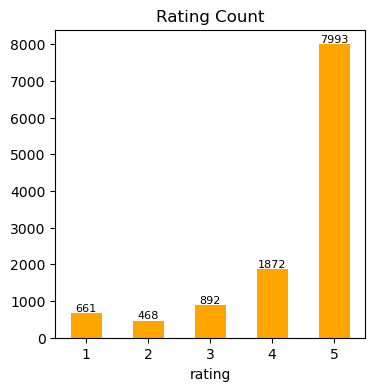

In [108]:
## Displays graphs directly within the notebook
%matplotlib inline 

ratings_count = filtered_df.groupby('rating').size()

ax = ratings_count.plot(kind = 'bar', figsize = (4,4), color = 'orange')

ax.tick_params(axis='x', rotation=0)

# Add labels above the bars
for i in ax.containers:
    ax.bar_label(i, fontsize=8)
    
ax.set_title('Rating Count');

#### How many reviews are there per year?

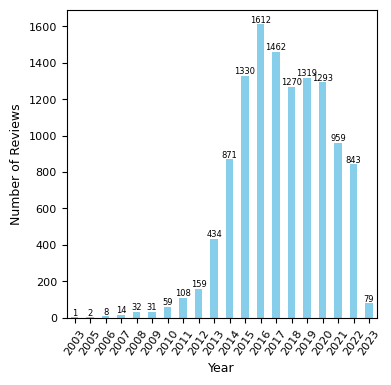

In [109]:
reviews_per_year = filtered_df.groupby('year').size()
ax = reviews_per_year.plot(kind = 'bar', figsize = (4,4), color = 'skyblue')
ax.tick_params(axis='x', rotation=55)
for i in ax.containers:
    ax.bar_label(i, fontsize=6)
ax.set_xlabel('Year', fontsize=9)
ax.set_ylabel('Number of Reviews', fontsize=9)
ax.tick_params(axis='both', labelsize=8)  # Set font size for y-axis ticks;


## Phrase Finder Using Gensim

Gensim's Phrases model applies a score to each two-word or three-word phrase (bigram or trigram), indicating how likely the words form a meaningful phrase rather than appearing together by chance. 

### Preprocess text column

In [49]:
# Tokenize function 
def sentence_tokenize(text):
    return sent_tokenize(text)

# Apply 
nlp_application = filtered_df.copy()
nlp_application['sentences'] = nlp_application['text'].apply(sentence_tokenize)
nlp_application[['text', 'sentences']].head(2)

,text,sentences
18385,"Great cooler! Compact, yet big enough to carr...","[Great cooler!, Compact, yet big enough to car..."
18386,This is really lunch box. It's too small for ...,"[This is really lunch box., It's too small for..."


In [163]:
def preprocess_sentence(sentence):
    # Tokenize text
    tokens = word_tokenize(sentence.lower())
    # Remove punctuation and non-alphanumeric characters (keep words and numbers)
    tokens = [word for word in tokens if re.match(r'^[a-zA-Z0-9]+$', word)]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to each sentence
nlp_application['preprocessed_sentences'] = nlp_application['sentences'].apply(lambda sentences: [preprocess_sentence(sentence) for sentence in sentences])

# Flatten the list of preprocessed sentences to fit the Phrases object
all_preprocessed_sentences = [sentence for sentences in nlp_application['preprocessed_sentences'] for sentence in sentences]

In [67]:
i = 18386
print(f'Text: {nlp_application.loc[i,"text"]}\n')

print(f'Sentences: {nlp_application.loc[i,"sentences"]}\n')

print(f'Preprocessed sentences: {nlp_application.loc[i,"preprocessed_sentences"]}')

Text: This is really lunch box.  It's too small for much more than that. But it's a good brand I will use it on the beach.

Sentences: ['This is really lunch box.', "It's too small for much more than that.", "But it's a good brand I will use it on the beach."]

Preprocessed sentences: [['really', 'lunch', 'box'], ['small', 'much'], ['good', 'brand', 'use', 'beach']]


### Create bigrams

In [110]:
# Create bigrams
bigram_finder = Phrases(
    sentences=all_preprocessed_sentences,
    min_count=25,
    connector_words=ENGLISH_CONNECTOR_WORDS,
    threshold = 25
)

bigrams_list = sorted(bigram_finder.find_phrases(all_preprocessed_sentences).items(), key = lambda x: -x[1])
bigrams_list

[('cup_holder', 417.9044752157335),
 ('customer_service', 288.233918128655),
 ('heavy_duty', 174.05215501629843),
 ('highly_recommended', 161.9590251170711),
 ('highly_recommend', 151.6206022833178),
 ('waste_money', 147.57857330876547),
 ('power_outages', 130.2678232583356),
 ('rain_fly', 116.38573317876794),
 ('years_ago', 110.12308703969393),
 ('cup_holders', 106.08344370860927),
 ('year_old', 96.7037243428996),
 ('air_mattresses', 86.52021604938271),
 ('24_hours', 85.8417121613022),
 ('stuff_sack', 83.80851063829788),
 ('plenty_room', 81.64424057084608),
 ('air_mattress', 81.64424057084608),
 ('carrying_case', 79.66260067137273),
 ('lunch_box', 78.73368606701939),
 ('ca_wait', 78.0579185520362),
 ('worth_money', 77.85579094833749),
 ('clear_ice', 66.62519310754605),
 ('degree_weather', 65.77039936495771),
 ('10_minutes', 63.77356470168309),
 ('road_trip', 63.46513470681458),
 ('5_stars', 63.35814140471003),
 ('happy_purchase', 61.341404501001534),
 ('move_around', 58.74282537203965

### Create trigrams

In [111]:
trigram_finder = Phrases(
    sentences = bigram_finder[all_preprocessed_sentences],
    min_count = 5,
    connector_words = ENGLISH_CONNECTOR_WORDS,
    threshold = 25
)

trigrams_list = sorted(
    filter(
        lambda x: x[0].count('_') >= 2,   # Make sure that there are at least 3 words in the phrase
        trigram_finder.find_phrases(bigram_finder[all_preprocessed_sentences]).items()
    ),
    key = lambda x: -x[1]   # Sort by score
)
trigrams_list

[('crystal_clear_ice', 1098.168249660787),
 ('gets_job_done', 392.41212121212124),
 ('making_clear_ice', 353.1033295063146),
 ('clear_ice_cubes', 268.44112769485906),
 ('clear_ice_cocktails', 254.31264728986648),
 ('queen_size_air_mattress', 167.53668188736683),
 ('ca_go_wrong', 150.38089929394278),
 ('give_5_stars', 137.92050922213312),
 ('queen_air_mattress', 134.5261065943993),
 ('make_clear_ice', 112.20644966847497),
 ('given_5_stars', 110.71819425444596),
 ('11_year_old', 104.5671834625323),
 ('hard_plastic_liner', 102.15547905909352),
 ('keeps_things_cold', 93.71765181096),
 ('reusable_ice_packs', 77.08095238095238),
 ('90_degree_weather', 76.35377358490567),
 ('queen_size_mattress', 76.22303082191782),
 ('less_10_minutes', 67.61487050960734),
 ('10_year_old', 60.07050964868876),
 ('year_old_son', 56.10922039452953),
 ('recent_camping_trip', 52.98527004909984),
 ('twin_air_mattress', 48.500374531835206),
 ('road_trip_grill', 46.359835032649784),
 ('40_degree_weather', 44.46978021

## Topic Modeling

Unsupervised NLP technique used to discover hidden topics in text documents.

In [171]:
# Use the preprocessing function made in the Phrase Finder to create tokens 
nlp_application['tokens'] = nlp_application['text'].apply(preprocess_sentence)

In [183]:
# Create a dictionary using Gensim
dictionary = Dictionary(nlp_application['tokens'])

# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus 
corpus = [dictionary.doc2bow(doc) for doc in nlp_application['tokens']]

Parameters for filter_extremes attributes:
- No_below: Tokens that appear in less than 5 documents are filtered out.
- No_above: Tokens that appear in more than 50% of the total corpus are also removed as default.
- Keep_n: Limit to the top 1000 most frequent tokens. 'None' will keep all. 

### Latent Dirichlet Allocation (LDA) w/ Gensim
Coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). Values above 0.5 are good. 

C_umass returns negative values. 

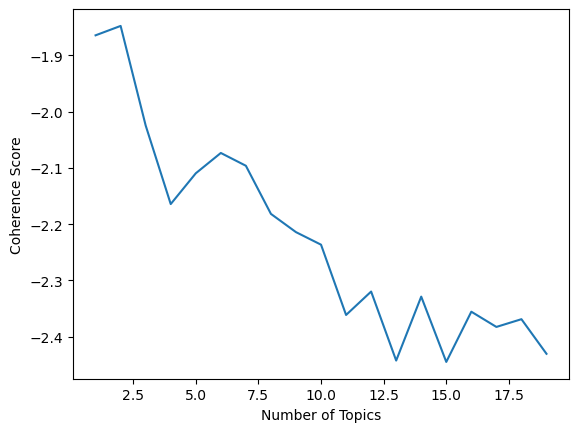

In [188]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

# Calculate coherence score using C_umass
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

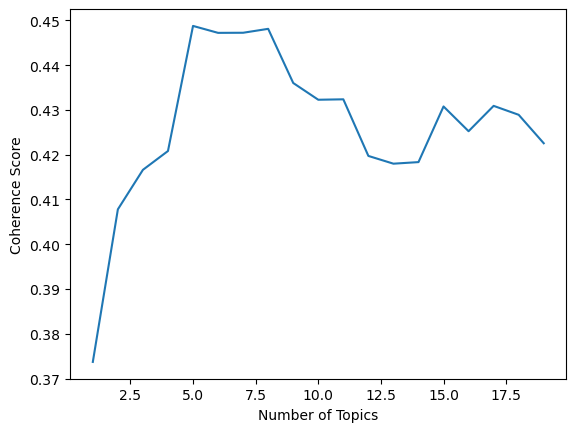

In [187]:
# Calculate coherence score using C-v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = nlp_application['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [189]:
lda_model.print_topics(-1)

[(0,
  '0.053*"air" + 0.039*"mattress" + 0.030*"bed" + 0.026*"pump" + 0.023*"easy" + 0.021*"use" + 0.019*"camping" + 0.017*"one" + 0.013*"used" + 0.013*"comfortable"'),
 (1,
  '0.060*"lantern" + 0.045*"coleman" + 0.021*"light" + 0.019*"one" + 0.016*"new" + 0.015*"batteries" + 0.014*"battery" + 0.012*"bright" + 0.011*"like" + 0.011*"replacement"'),
 (2,
  '0.052*"grill" + 0.033*"excellent" + 0.032*"coleman" + 0.023*"handle" + 0.019*"item" + 0.018*"purchased" + 0.016*"fit" + 0.015*"product" + 0.014*"would" + 0.014*"return"'),
 (3,
  '0.077*"water" + 0.027*"34" + 0.021*"bottle" + 0.020*"nice" + 0.020*"bottles" + 0.018*"heavy" + 0.015*"little" + 0.013*"hard" + 0.011*"would" + 0.010*"bit"'),
 (4,
  '0.090*"cooler" + 0.037*"cold" + 0.021*"keeps" + 0.021*"ice" + 0.021*"day" + 0.018*"keep" + 0.017*"lid" + 0.014*"food" + 0.013*"drinks" + 0.012*"br"'),
 (5,
  '0.103*"ice" + 0.021*"cooler" + 0.019*"great" + 0.016*"hours" + 0.015*"use" + 0.015*"days" + 0.014*"clear" + 0.013*"bought" + 0.013*"ok" +

In [213]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [212]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [214]:
# Save the report
pyLDAvis.save_html(lda_display, 'index.html')

### SVD (Singular Value Decomposition)
- Aka Latent Semantic Indexing (LSI).
- Reduces dimensionality to reveal latent structures.

In [232]:
svd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components = 7))
])

svd_pipe.fit(nlp_application['text'])
svd_vocab = svd_pipe.named_steps['tfidf'].get_feature_names_out()
svd_components = svd_pipe.named_steps['svd'].components_

In [236]:
topic_num = 3

pd.DataFrame({
    'word': svd_vocab,
    'weight': svd_components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
8477,perfect,0.449221
4991,for,0.253453
7096,love,0.252321
6470,it,0.226791
3029,cooler,0.220336
10546,size,0.189621
7136,lunch,0.146580
7703,my,0.126065
7824,nice,0.122417
6057,ice,0.115249


### NMF (Non-negative Matrix Factorization)
- Decomposes the term-document matrix into:
    - W (Document-Topic Matrix): Distribution of topics across documents.
    - H (Term-Topic Matrix): Significance of terms across topics.
- Advantages:
    - Easier interpretation due to non-negative values.
    - Higher scores indicate stronger relevance.

In [218]:
nmf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components = 7))
])

nmf_pipe.fit(nlp_application['text'])

nmf_vocab = nmf_pipe.named_steps['tfidf'].get_feature_names_out()
nmf_components = nmf_pipe.named_steps['nmf'].components_

C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [225]:
topic_num = 2

pd.DataFrame({
    'word': nmf_vocab,
    'weight': nmf_components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
5371,good,3.013719
9011,product,0.617747
9184,quality,0.520459
8952,price,0.313126
12628,very,0.221458
3029,cooler,0.095021
12548,value,0.092775
4991,for,0.083346
2093,but,0.078789
4818,fit,0.053590


## Text Summarization

### Using TF-IDF 

Use TF-IDF vectorizer to transform the text into vectors based on the frequency of words in the text.

Consider single-word and two-word sequences that appear at least 50 times and find words that are similar to each other.

In [ ]:
# Parameter to specify number of summary sentences 
num_summary_sentence = 4

# Sort the sentences in descending order by the sum of TF-IDF values 
sent_sum = tfidf_text.sum(axis = 1)
important_sent = np.argsort(sent_sum, axis = 0)[::-1]

# Print three most import sentences in the order they appear in the article 
for i in range(0, len(sentences)):
    if i in important_sent[:num_summary_sentence]:
        print (sentences[i])

In [ ]:
def summarize_with_tfidf(doc, num_summary_sentence = num_summary_sentence)
    """
    Apply the TF-IDF vectorization and then aggregate the value to a sentence level.
    Generate a score for each sentence as a sum of the TF-IDF values for each word in that sentence. 
    A sentence with a high score contains many important words as compared to other sentences in the column.
    """

    # Tokenize the text into sentences 
    sentences = []
    for text in doc:
        sentences.extend(sent_tokenize(text))

    # Compute TF-IDF for the sentences 
    tfidf = TfidfVectorizer()
    tfidf_text = tfidf.fit_transform(sentences)
    
    # Sort the sentences in descending order by the sum of TF-IDF values 
    sent_sum = tfidf_text.sum(axis = 1)
    important_sent = np.argsort(sent_sum, axis = 0)[::-1].flatten()
    
    # Collect the most important sentences 
    summary_sentences = [sentences[i] for i in important_sent[:num_summary_sentence]]

    return summary_sentences

In [ ]:
num_summary_sentence = 4
summarize_with_tfidf(filtered_df['text'])

### Using LSA 
Latent semantic analysis (LSA) assumes that words that are close in meaning will occur in the same documents. Use package sumy to provide multiple summarization methods. 

In [ ]:
LANGUAGE = 'english'
stemmer = Stemmer(LANGUAGE)

parser = PlaintextParser.from_string(filtered_df['text'], Tokenizer(LANGUAGE))
summarizer = LsaSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, num_summary_sentence):
    print (str(sentence))

In [ ]:
summary_sentence = tfidf_summary = 